# Subset discontinuity tracking
This deck contains proofing of subset splitting methodologies

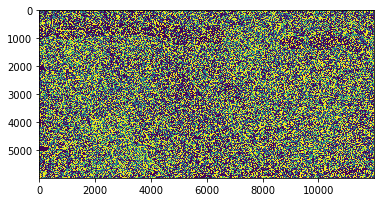

In [1]:
# preamble

import matplotlib.pyplot as plt
from pathlib import Path
from crosspy import DIC, Imset
import os

# folder path

folder_path=Path(r'/Users/tom/Documents/GitHub/crosspy/data/Ben')
Images = Imset(folder_path,'tif')

plt.imshow(Images.imload([1]))


2

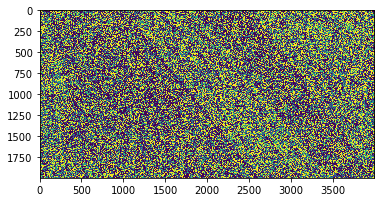

In [2]:
# Image crop

import cv2
img = Images.imload([0,1])
y = 2000
h = 2000
x = 4000
w = 4000
Images = img[y:y+h, x:x+w, :]
plt.imshow(Images[:,:,1])
Images.shape[2]



In [3]:
# first pass settings

filter_settings=[4,2,15,8]
roi_1stpass = dict(size_pass = 300, overlap_percentage = 60, xcf_mesh=600)

# first pass

dic_1stpass = DIC(Images,roi_1stpass,filter_settings)
dic_1stpass.run_sequential()

Running sequential DIC on image pair 1 of 1 ...


/Users/tom/opt/anaconda3/envs/tpm/lib/python3.7/site-packages/crosspy/XCF.py:204: ComplexWarning: Casting complex values to real discards the imaginary part
  return col_shift, row_shift, CCmax/np.sqrt(float(bf1*bf2))


... Completed in (s) 18.29359197616577


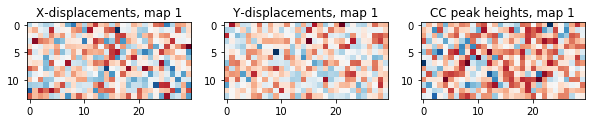

In [4]:
dic_1stpass.plot_displacements()


Correcting images based on DIC results ...


/Users/tom/opt/anaconda3/envs/tpm/lib/python3.7/site-packages/crosspy/ImageCorrection.py:168: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_params,_,_,_=np.linalg.lstsq(A,x_measured_1d)
/Users/tom/opt/anaconda3/envs/tpm/lib/python3.7/site-packages/crosspy/ImageCorrection.py:169: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  y_params,_,_,_=np.linalg.lstsq(A,y_measured_1d)


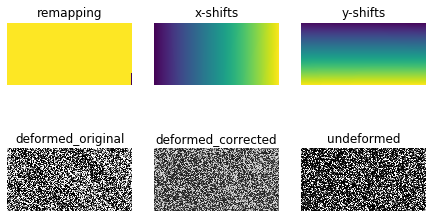

... Completed in (s) 3.176985025405884


In [5]:
images_corrected=dic_1stpass.correct(method='polynomial',printing=1)

Crop edges

In [6]:
images_corrected.shape

(1999, 3999, 2)

## Step 1 : identify subsets with kinematic discontinuities
Subsets with discontinuities may be identified by peak heigh mistmatch, extreme displacements

600


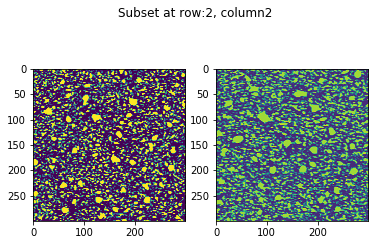

In [7]:
import cv2


#settings for heaviside pass
roi_disc = dict(size_pass = 300, overlap_percentage = 70, xcf_mesh=250)
dic_disc = DIC(images_corrected, roi_disc,filter_settings)

# Function to plot selected subsets

def get_subsets(ims, row=0, col=0, roi_settings=None):
    if roi_settings==None:
        roi_settings = dict(
            size_pass = 100, 
            overlap_percentage = 70, 
            xcf_mesh=250)
    x0 = (col) * roi_settings['size_pass']
    x1 = x0 + roi_settings['size_pass']
    y0 = (row) * roi_settings['size_pass']
    y1 = y0 + roi_settings['size_pass']
    
    print(x0)
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Subset at row:{}, column{}'.format(row,col))
    images = []
    for i in range(0,ims.shape[2]):
        images.append(axs[i].imshow(ims[x0:x1, y0:y1, i]))
        
    subsets = ims[x0:x1, y0:y1, :]
    return subsets
    
# Select a subset, here at row 20, column 20

subsets = get_subsets(images_corrected,2, 2, roi_disc)


In [8]:
from numba import double, jit

<IPython.core.display.Javascript object>


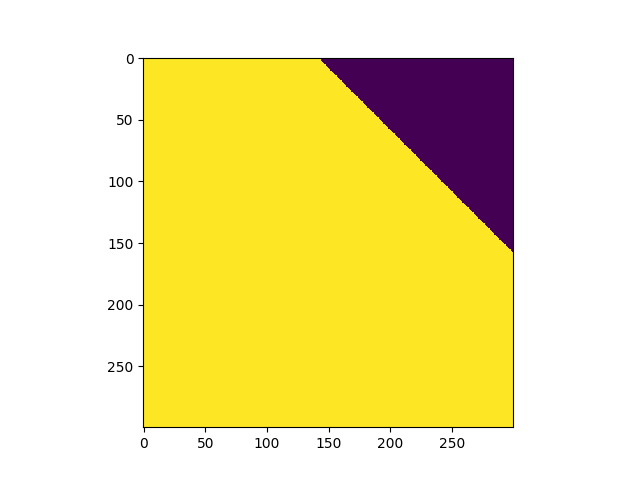

In [78]:
%matplotlib notebook

import numpy as np

# Apply a line and step function

#@jit(nopython=True)

class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 
    
def line_test(pixel, r, theta, imarray):
    # Find start and end points of line segments for different cases of theta and r
    dx = imarray.shape[0]
    # Line segment to interogation point
    p1 = Point(0, 0)
    q1 = Point(pixel[0], pixel[1])
    
    # Vector magnitude cases
    
    if r == 0:
        r = 1e-8
        
    # Rotation cases
    if theta == 0. or theta == 360.: # vertical to right
        x1 = r
        x2 = q1.x
        if x2 > x1:
            return False
        else:
            return True
    elif theta == 90.: # horizontal line above
        y1 = r
        y2 = q1.y
        if y2>y1:
            return False
        else:
            return True
    elif theta == 180.: # vertical to left
        x1 = r
        x2 = q1.x
        if x2 < x1:
            return False
        else:
            return True
    elif theta == 270.: # horizontal below
        y1 = r
        y2 = q1.y
        if y2 < y1:
            return False
        else:
            return True
    elif theta>0 and theta<180:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        y1 = q1.y
        y2 = m*q1.x + c
        if y1>y2:
            return False
        else:
            return True
    elif theta>180 and theta<360:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        
        y1 = q1.y
        y2 = m*q1.x + c
        if y1<y2:
            return False
        else:
            return True
        
    

#@jit(nopython=True)
def subset_hsfilter(imarray, r, theta):
    #filters ONE subset - imarray should be 2D
    
    if type(imarray) == list:
        imarray = imarray[0]
    # preallocate
    hsfilter = np.zeros((imarray.shape[0],imarray.shape[0]))
    xc = hsfilter.shape[0]/2
    yc = hsfilter.shape[1]/2
    xc = int(xc)
    yc = int(yc)
    
    # Create x and y coordinates which are centred
    xs,ys = np.meshgrid(range(-xc, xc), range(-yc,yc))
    
    
    for col in range(imarray.shape[0]):
        for row in range(imarray.shape[0]):
            #rasters through columns and rows for a given coordinate in xy
            x = xs[row,col]
            y = ys[row,col]
            # Note that y axis is mirrored
            pixel = [x, (-1*y)]
            
            # Test if pixel is beyond the discontinuity line
            if line_test(pixel, r, theta, imarray):
                hsfilter[row,col] = 1
            else:
                hsfilter[row,col] = False
                
    
    return hsfilter.astype(bool)

filt = subset_hsfilter(subsets[:,:,0],r=100, theta=45)
plt.imshow(filt)

# result = subset_hsfilter(subsets[:,:,0],r=100, theta=45)

# ref_subset_1=result[:,:,0]
# ref_subset_2=result[:,:,1]

# ref_subset=subsets[:,:,0]
# test_subset=subsets[:,:,1]

# f, axarr = plt.subplots(nrows=1,ncols=4)
# axarr[0].imshow(ref_subset_1)
# axarr[1].imshow(ref_subset_2)
# axarr[2].imshow(test_subset)
# axarr[3].imshow(ref_subset)

In [77]:
filt = subset_hsfilter(subsets[:,:,0],r=50, theta=15)

ref=subsets[:,:,0]
test=subsets[:,:,1]

ref1=ref[filt]
ref2=ref[np.invert(filt)]
test1=test[filt]
test2=test[np.invert(filt)]

side1_length=len(ref1)
side2_length=len(ref2)

from scipy.signal import correlate
side1=max(correlate(ref1,test1))/(side1_length)
side2=max(correlate(ref2,test2))/(side2_length)
full=max(correlate(subsets[:,:,0].flatten(),subsets[:,:,1].flatten()))/(subsets.shape[0]**2)

print(side1,side2,full)
(side1>full) & (side2>full)



8335.820313659526 8558.527570586833 8304.443733333334


True

In [308]:
from scipy.signal import correlate
def hs_corr(x, imarrays):
        
        r, theta = x
        #if r == False and theta == False:
            #filtered_subsets = imarrays
        #else:
            #apply filter
            #filtered_subsets = subset_hsfilter(imarrays, r, theta)
        
        filtered_subsets = subset_hsfilter(imarrays, r, theta)
        # flatten to 1d arrays
        undeformed = []
        test = []
        for j in range(filtered_subsets.shape[0]):
            for i in range(filtered_subsets.shape[1]):
                # We filter for False values as these correlate
                if filtered_subsets[i,j,0] == True:
                    undeformed.append(filtered_subsets[i,j,0])
                    test.append(filtered_subsets[i,j,1])
        
        undeformed = np.asarray(undeformed)
        test = np.asarray(test)
        
        norm = np.sqrt(np.dot(undeformed**2,test**2))
        undeformed = undeformed/norm
        test = test/norm
        
        # cross correlate
        
        #dxc = correlate(underformed, test, method="fft")
        dxc = np.correlate(undeformed,test)
        resids = 1/dxc
        
        
        return resids

hs_corr([175,0], ia)


array([192.38995715])

We now have to use a function to identify discontinuities

     fun: 191.78291876436674
    funl: array([191.78291876])
 message: 'Optimization terminated successfully.'
    nfev: 9
     nit: 2
   nlfev: 4
   nlhev: 0
   nljev: 1
 success: True
       x: array([ 50. , 179.5])
      xl: array([[ 50. , 179.5]])


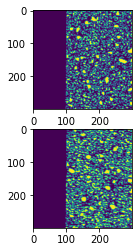

In [309]:
import scipy.optimize as optimize

def disc_calc(x0, imarray, lb, ub):
    
    bounds = [(0,imarray.shape[0]/3), (0,359)]
    params = optimize.shgo(hs_corr,bounds=bounds, args=([imarray]))
    
    return params

def hs_optimisation(imarray):
    # Initial naked cross-correlation
    #dx, dy, cc = freg()
    
    # minimise to obtain an initial guess
    
    lb = [1., 1.]
    ub = [imarray.shape[0], 359.]
    x0 = [1., 90.]
    arg = imarray
    output = disc_calc(x0,imarray, lb, ub)
    print(output)
    r, theta = output.x
    return r, theta
        
    
r, theta = hs_optimisation(ia)
result = subset_hsfilter(ia,r=r, theta=theta)

f, axarr = plt.subplots(2)
axarr[0].imshow(result[:,:,0])
axarr[1].imshow(result[:,:,1])
        
    
    

## Fine pass

Running sequential DIC on image pair 1 of 1 ...
... Completed in (s) 9338.238300085068


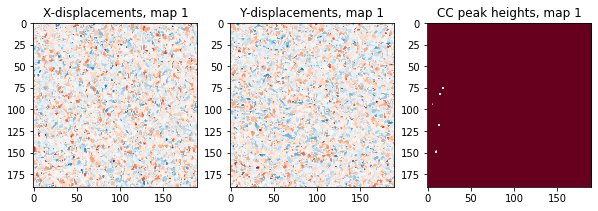

Calculating strain on map 1 of 1 ...
... Completed in (s) 27.462647914886475
Quick plotting strains


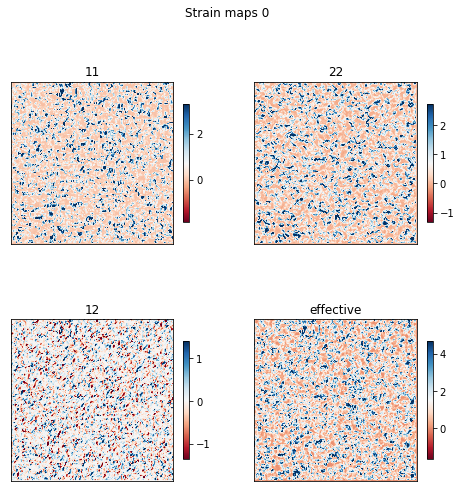

In [15]:
roi_2ndpass = dict(size_pass = 100, overlap_percentage = 90, xcf_mesh=250)
dic_2ndpass = DIC(images_corrected,roi_2ndpass,filter_settings)

# # run the second pass
dic_2ndpass.run_sequential()
dic_2ndpass.plot_displacements()

dic_2ndpass.calculate_strain(strain_method='l2')
dic_2ndpass.plot_strains()

Quick plotting strains


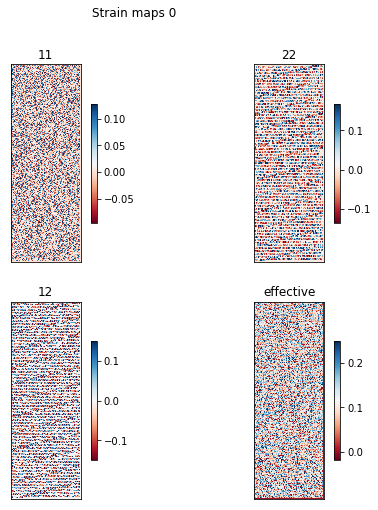

In [31]:
# # strain calc

dic_2ndpass.plot_strains()

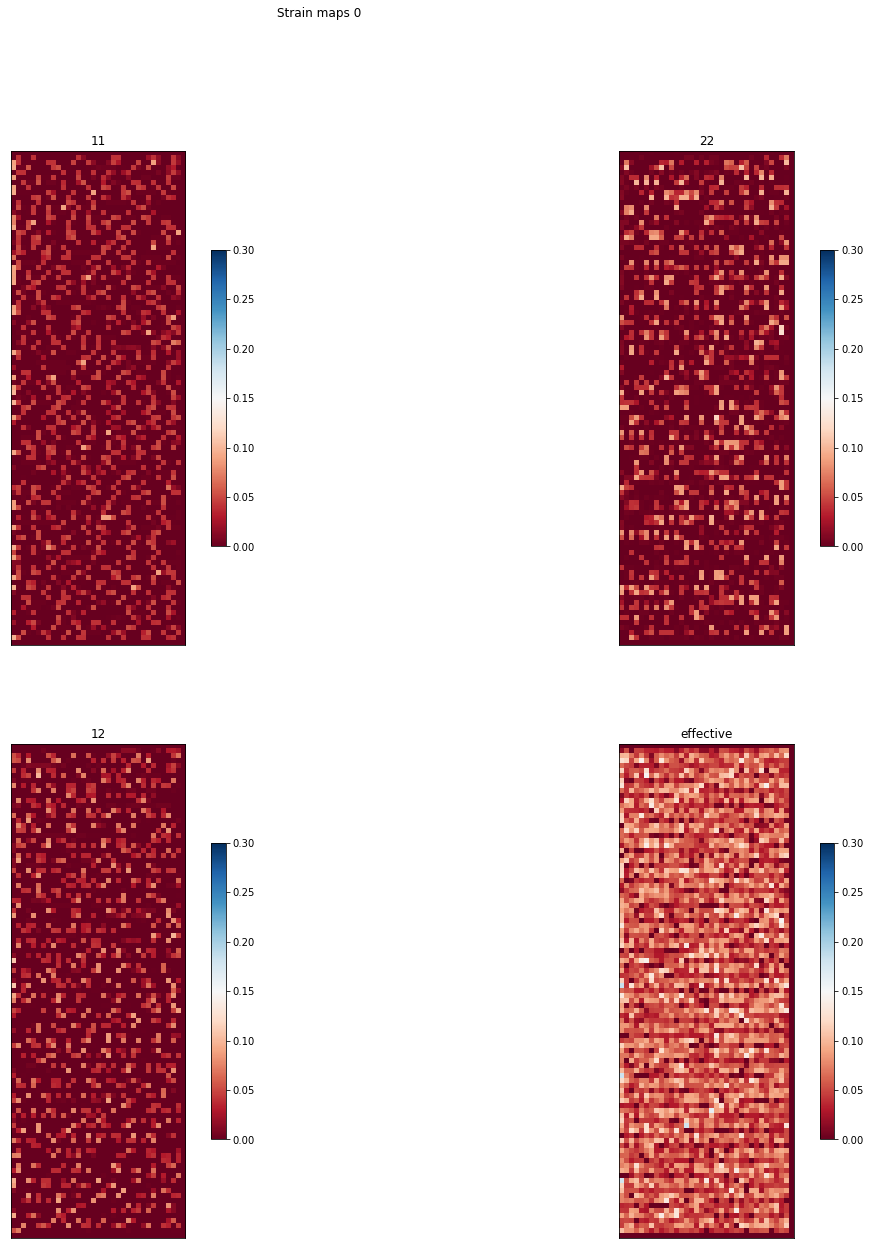

In [29]:
def plot_4(d, num, cmap):

    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    fig.suptitle('Strain maps '+str(num))
    Nr = 2
    Nc = 2
    images = []
    data = [d.strain_11[:,:,num], d.strain_22[:,:,num], d.strain_12[:,:,num], d.strain_eff[:,:,num]]
    names = ["11", "22", "12", "effective"]
    no = 0
    for i in range(Nr):
        for j in range(Nc):
            vmin = np.mean(data[no].flatten()) - 1*np.std(data[no].flatten())
            vmax = np.mean(data[no].flatten()) + 1*np.std(data[no].flatten())
            images.append(axs[i, j].imshow(data[no], cmap=cmap, vmin=0, vmax=0.3))
            axs[i, j].set_title(names[no])
            axs[i, j].label_outer()
            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            fig.colorbar(images[no], ax=axs[i,j], shrink=0.6)
            no += 1
    plt.show()
    
    
    return fig, axs

fig, axs = plot_4(dic_2ndpass, 0, 'RdBu')

fig.savefig('STRAINS_'+str(roi_2ndpass['size_pass'])+'_'+str(roi_2ndpass['overlap_percentage']), dpi=400)